In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib notebook

Загрузим и проанализируем данные

In [2]:
data = pd.read_csv('RDC_samples/train.csv')

In [3]:
data.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,10.0.151.43,10.0.16.14,TCP,1026,"8000 > 63774 [PSH, ACK] Seq=1 Ack=1 Win=229 ..."
1,2,0.000004,10.0.151.43,10.0.16.14,TCP,1026,"[TCP Retransmission] 8000 > 63774 [PSH, ACK]..."
2,3,0.000019,10.0.4.66,10.0.17.129,TCP,70,445 > 36384 [ACK] Seq=1 Ack=1 Win=2573 Len=0...
3,4,0.000021,10.0.4.66,10.0.17.129,TCP,70,[TCP Dup ACK 3#1] 445 > 36384 [ACK] Seq=1 Ac...
4,5,0.000055,10.0.16.14,10.0.151.43,TCP,64,63774 > 8000 [ACK] Seq=1 Ack=1 Win=4096 Len=0


In [4]:
data.Protocol.count()

269306

In [5]:
data.Protocol.loc[data.Protocol == 'TCP'].count()

269306

In [6]:
data.Info.apply(lambda x: x.find('Win') != -1).count()

269306

Распарсим колонку Info и оцифруем Ip адреса 

In [7]:
def parse_data(par_list):
    par_list = par_list.split()

    if not par_list[0].isdigit():
        counter = 0
        while not par_list[counter].isdigit():
            counter+=1        
        par_list = par_list[counter:]

    source_port = int(par_list[0])
    destination_port = int(par_list[2])
    windows_size_val = 0

    for it in par_list:
        if it.find('Win')!=-1:
            windows_size_val = int(it[4:])
            break
    return [source_port, destination_port, windows_size_val]

In [8]:
def data_init(file_name='train.csv'):
    data = pd.read_csv('RDC_samples/'+file_name)
    data['params'] = data.Info.apply(parse_data)
    data[['source_port', 'destination_port', 'windows_size_val']] = pd.DataFrame(data.params.tolist(), index=data.index)
    data = data.drop(columns=['params', 'Info', 'Protocol', 'Time', 'No.'])
    data.Source = data.Source.apply(lambda x: int(x.replace('.', '')) if x.replace('.', '').isdigit() else None)
    data.Destination = data.Destination.apply(lambda x: int(x.replace('.', '')) if x.replace('.', '').isdigit() else None)
    return data

In [9]:
data = data_init('train.csv')

In [10]:
data.head()

,Source,Destination,Length,source_port,destination_port,windows_size_val
0,10015143,1001614,1026,8000,63774,229
1,10015143,1001614,1026,8000,63774,229
2,100466,10017129,70,445,36384,2573
3,100466,10017129,70,445,36384,2573
4,1001614,10015143,64,63774,8000,4096


Посмотрим сколько уникальных элементов и построим гистограммы, чтобы понять, какие элементы считать аномалиями

In [11]:
data.nunique()

Source               31
Destination          40
Length              497
source_port         162
destination_port     90
windows_size_val    607
dtype: int64

<IPython.core.display.Javascript object>


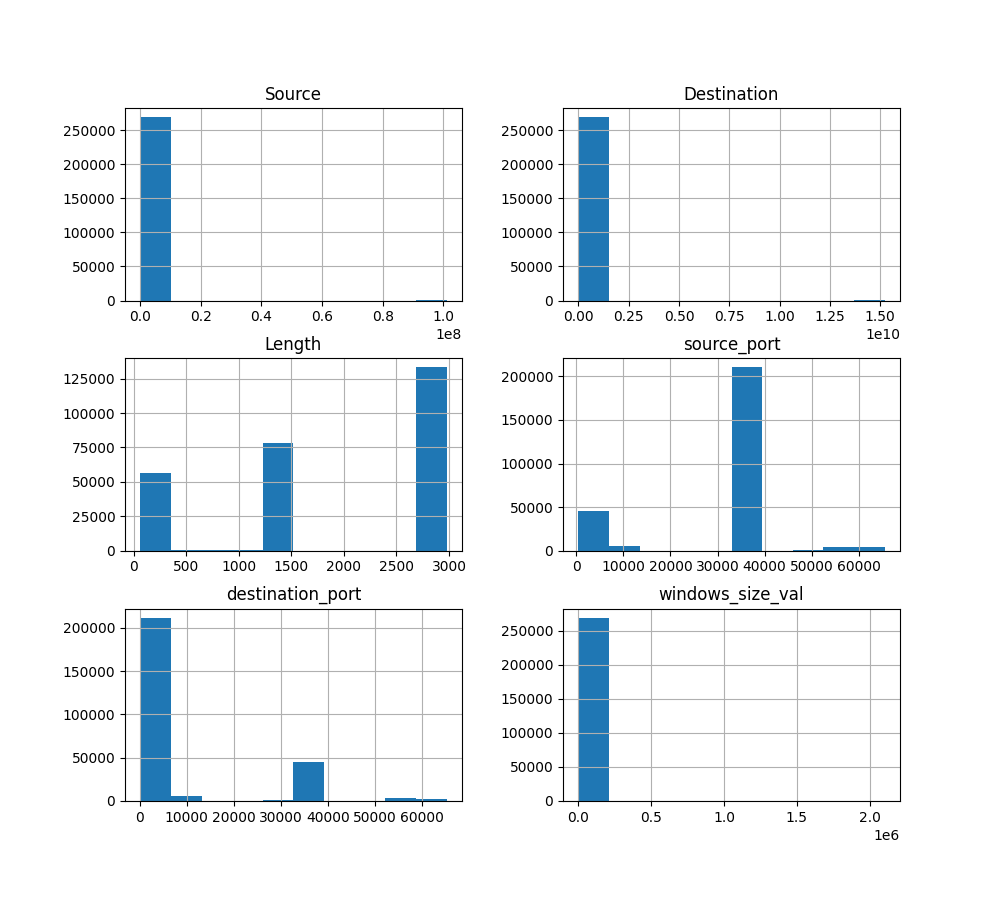

array([[<AxesSubplot:title={'center':'Source'}>,
        <AxesSubplot:title={'center':'Destination'}>],
       [<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'source_port'}>],
       [<AxesSubplot:title={'center':'destination_port'}>,
        <AxesSubplot:title={'center':'windows_size_val'}>]], dtype=object)

In [12]:
data.hist(figsize=(10, 9))

In [13]:
data_copy = data

<IPython.core.display.Javascript object>


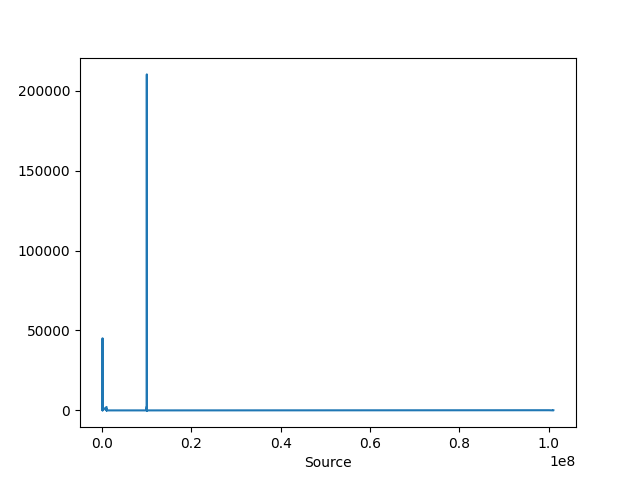

<AxesSubplot:xlabel='Source'>

In [14]:
plt.figure()
data.groupby('Source').Destination.count().rename({'Destination':'count'}).plot()

Заметим, что практически все запросы приходили с 2-ух ресурсов, поэтому избавимся от всех остальных элеметов, чтобы не переобучить модель на выбросах 

In [15]:
fil_sources = data.groupby('Source').Destination.count().sort_values(ascending=False)[:2].index

In [16]:
fil_sources

Int64Index([10017129, 100466], dtype='int64', name='Source')

In [17]:
data = data.loc[(data.Source == fil_sources[0]) | (data.Source == fil_sources[1])] 

In [18]:
data.groupby('Source').Destination.count().sort_values(ascending=False)

Source
10017129    210250
100466       45116
Name: Destination, dtype: int64

In [19]:
fil_destination = data.groupby('Destination').Source.count().sort_values(ascending=False)

In [20]:
fil_destination

Destination
100466      210230
10017129     44676
1001650        350
10017177        66
10016247        24
1001782         12
100445           8
Name: Source, dtype: int64

In [21]:
fil_destination = fil_destination.index[:2]

In [22]:
data = data.loc[(data.Destination == fil_destination[0]) | (data.Destination == fil_destination[1])] 

In [23]:
data.groupby('Destination').Source.count().sort_values(ascending=False)

Destination
100466      210230
10017129     44676
Name: Source, dtype: int64

In [24]:
fil_length = data.groupby('Length').Source.count().sort_values(ascending=False)

In [25]:
fil_length

Length
2966    132716
1518     77514
70       41454
98        2036
82         626
90         500
154         60
Name: Source, dtype: int64

In [26]:
fil_length = fil_length.index[:3]

In [27]:
data = data.loc[(data.Length == fil_length[0]) | (data.Length == fil_length[1]) | (data.Length == fil_length[2])] 

In [28]:
data.groupby('Length').Source.count().sort_values(ascending=False)

Length
2966    132716
1518     77514
70       41454
Name: Source, dtype: int64

In [29]:
fil_sp = data.groupby('source_port').Source.count().sort_values(ascending=False)

In [30]:
fil_sp

source_port
36384    210230
445       41454
Name: Source, dtype: int64

In [31]:
fil_dp = data.groupby('destination_port').Source.count().sort_values(ascending=False)

In [32]:
fil_dp

destination_port
445      210230
36384     41454
Name: Source, dtype: int64

<IPython.core.display.Javascript object>


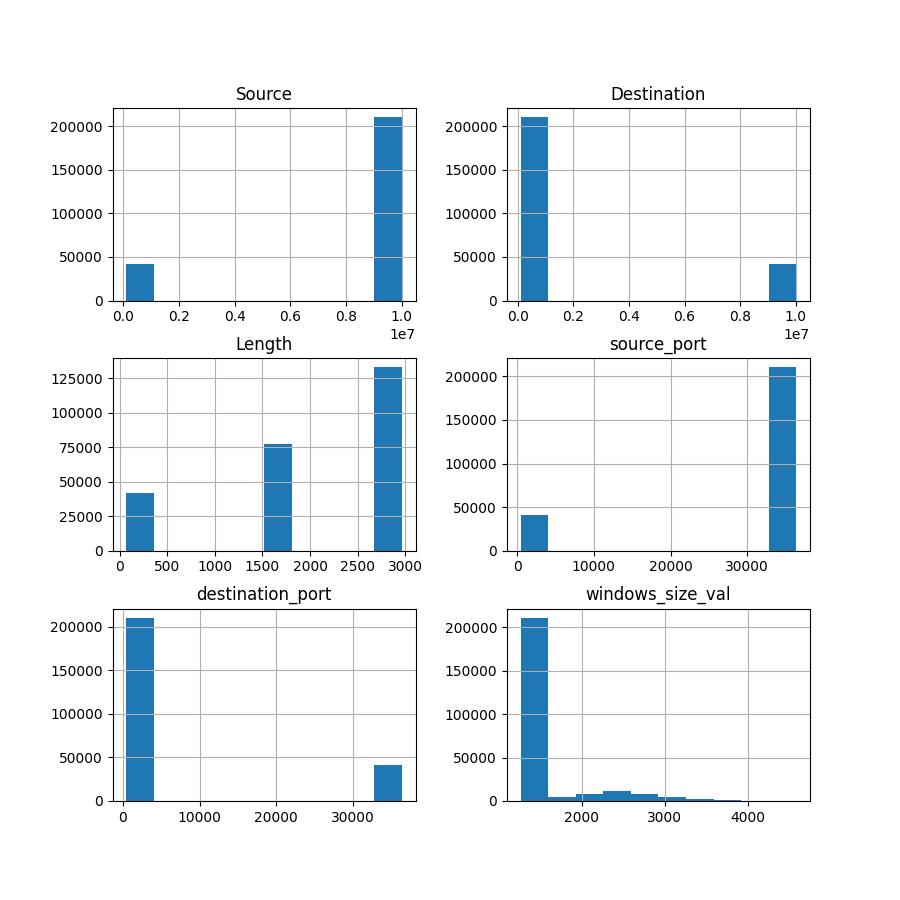

array([[<AxesSubplot:title={'center':'Source'}>,
        <AxesSubplot:title={'center':'Destination'}>],
       [<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'source_port'}>],
       [<AxesSubplot:title={'center':'destination_port'}>,
        <AxesSubplot:title={'center':'windows_size_val'}>]], dtype=object)

In [33]:
data.hist(figsize=(9,9))

In [34]:
fil_wsv = data.groupby('windows_size_val').Source.count().sort_values(ascending=False)

In [35]:
fil_wsv

windows_size_val
1259    210230
2403       298
2336       296
2341       292
2358       274
         ...  
4196         2
4208         2
4213         2
4038         2
2214         2
Name: Source, Length: 528, dtype: int64

In [36]:
fil_wsv = fil_wsv.index[0]

In [37]:
data_tmp = data.loc[(data.windows_size_val == fil_wsv)] 

<IPython.core.display.Javascript object>


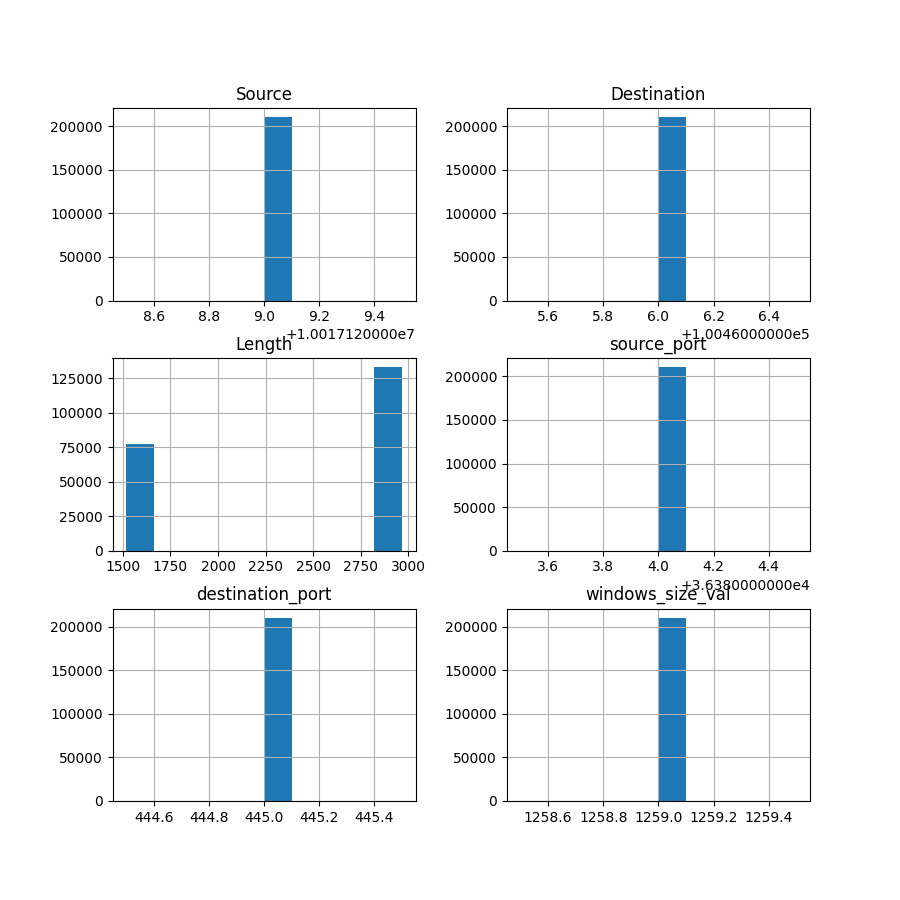

array([[<AxesSubplot:title={'center':'Source'}>,
        <AxesSubplot:title={'center':'Destination'}>],
       [<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'source_port'}>],
       [<AxesSubplot:title={'center':'destination_port'}>,
        <AxesSubplot:title={'center':'windows_size_val'}>]], dtype=object)

In [38]:
data_tmp.hist(figsize=(9,9))

После удаления выбросов в последнем параметре также удалили большую часть данных, которые скорее всего не были аномальными, потом вдальнейшем при обучении будем использовать данные в которых параметр windows_size_val не был отфильтрован

Создадим полносвязную нейронную сеть, задачей которой будет на выходе давать результат схожий с тем, что был на входе, тогда при наличии аномалий, нейронная сеть будет давать большую ошибку, что можно будет отследить

In [39]:
import torch
from torch import nn

In [40]:
X = torch.FloatTensor(np.asarray(data))

In [41]:
train_data_size = int(0.8*X.shape[0])
X_train, X_val = X[:train_data_size], X[train_data_size:]

In [42]:
X_train.shape

torch.Size([201347, 6])

In [43]:
X_val.shape

torch.Size([50337, 6])

In [44]:
features_count = X_train.shape[1]
rows = X_train.shape[0]
learning_rate = 1e-3
batch_size = 700
epochs = 5

In [45]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [46]:
model = nn.Sequential(
    nn.Linear(features_count, 32),
    nn.ReLU(),
    nn.Linear(32,48),
    nn.ReLU(),
    nn.Linear(48,64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,features_count)
)
model.to(device)

Sequential(
  (0): Linear(in_features=6, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=48, bias=True)
  (3): ReLU()
  (4): Linear(in_features=48, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=6, bias=True)
)

In [47]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [48]:
loss_history = []
for epoch in range(epochs):
    for b_num in range(rows//batch_size):
        batch_X = X_train[b_num*batch_size:(b_num+1)*batch_size]
        batch_X = batch_X.to(device)
        pred = model.forward(batch_X)
        loss = criterion(pred, batch_X)
        loss_history.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss_history[-1])

13406.4638671875
13723.107421875
30155.375
31664.755859375
13998.642578125


<IPython.core.display.Javascript object>


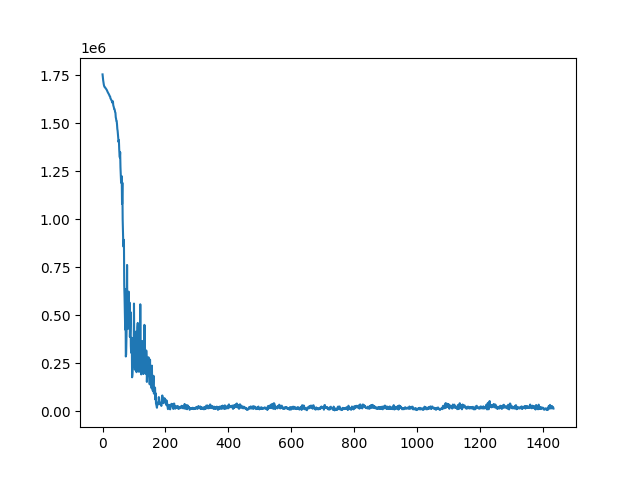

In [49]:
plt.figure()
plt.plot(loss_history)

In [50]:
loss_history[-1]

13998.642578125

Осталась достаточно большая ошибка, но при этом она стабильная, то есть если в данных будут аномалии, то ошибка, предположительно, будет гораздо больше

Сделаем прямой проход на валидационных данных и найдем l1 метрику для каждого элемента

In [51]:
def (X_to_pred):
    with torch.no_grad():
        rows = X_to_pred.shape[0]
        predictions = np.array([[0]*features_count])
        for b_num in range(rows//batch_size):
            batch_X = X_to_pred[b_num*batch_size:(b_num+1)*batch_size]
            pred = np.asarray(model.forward(batch_X))
            predictions = np.vstack((predictions, pred))
        batch_X = X_to_pred[(rows//batch_size)*batch_size:]
        pred = np.asarray(model.forward(batch_X))
        predictions = np.vstack((predictions, pred))
    return predictions[1:]

In [52]:
model.cpu()
preds = predict(X_val)
preds

array([[ 9.97404000e+06,  1.01814430e+05, -4.95399805e+03,
         5.25465352e+04,  1.83850183e+03,  2.11750723e+04],
       [ 9.97404000e+06,  1.01814430e+05, -4.95399805e+03,
         5.25465352e+04,  1.83850183e+03,  2.11750723e+04],
       [ 9.97381000e+06,  1.01808336e+05, -4.95349805e+03,
         5.25410977e+04,  1.84500183e+03,  2.11754473e+04],
       ...,
       [ 9.97404000e+06,  1.01814430e+05, -4.95399805e+03,
         5.25465352e+04,  1.83850183e+03,  2.11750723e+04],
       [ 9.97404000e+06,  1.01814430e+05, -4.95399805e+03,
         5.25465352e+04,  1.83850183e+03,  2.11750723e+04],
       [ 9.97381000e+06,  1.01808336e+05, -4.95349805e+03,
         5.25410977e+04,  1.84500183e+03,  2.11754473e+04]])

In [53]:
preds.shape

(50337, 6)

In [54]:
X_val_tmp = np.asarray(X_val)
losses = np.sum(np.abs(X_val_tmp - preds),axis=1)
print(losses.shape)
losses

(50337,)


array([89829.5369873, 89829.5369873, 88606.3807373, ..., 89829.5369873,
       89829.5369873, 88606.3807373])

<IPython.core.display.Javascript object>


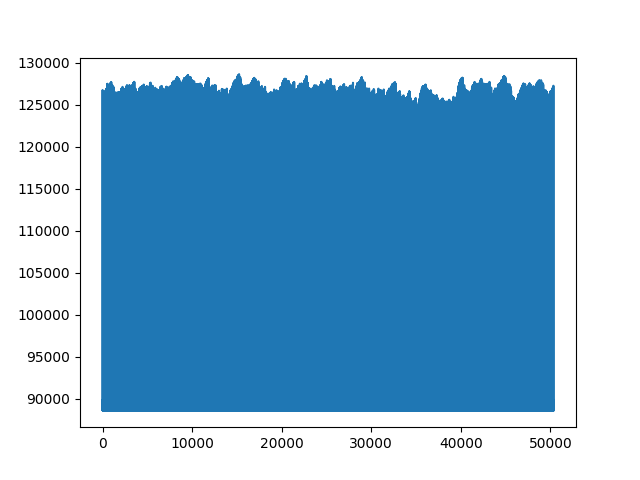

In [55]:
plt.figure()
plt.plot(losses)

Так как валидационные данные также были подвержены отчистке, на них мы аномальных значений не имеем, попробуем применить алгорим к необработанным валидационным данным


In [56]:
X = torch.FloatTensor(np.asarray(data_copy))
train_data_size = int(0.8*X.shape[0])
X_val = X[train_data_size:]

In [57]:
preds = predict(X_val)
X_val_tmp = np.asarray(X_val)
losses = np.sum(np.abs(X_val_tmp - preds),axis=1)
print(losses.shape)
losses

(53862,)


array([199378.6640625, 199378.6640625, 182480.9609375, ...,
        89829.5369873,  89829.5369873,  88606.3807373])

<IPython.core.display.Javascript object>


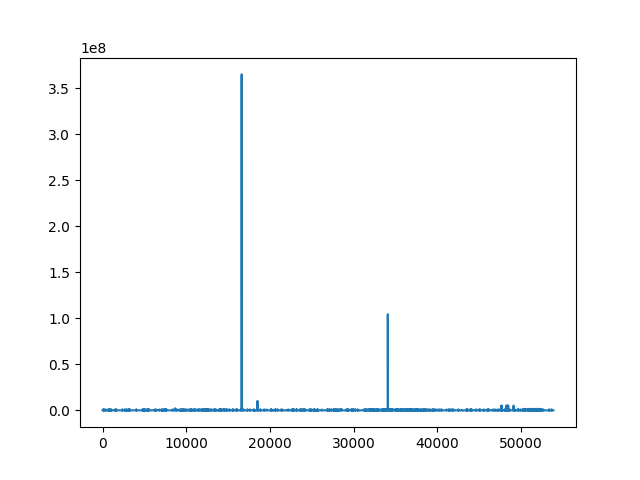

In [58]:
plt.figure()
plt.plot(losses)

In [59]:
losses = pd.Series(losses)
losses = losses.loc[losses > 0.5 * 1e8]

In [60]:
losses

16615    3.649069e+08
16616    3.649069e+08
34073    1.044564e+08
34074    1.044564e+08
dtype: float64

Как видим на необработанных данных получилось найти индексы аномальных элементов в тестовом датасете

Проведем аналогичный анализ на первом тестовом датасете

In [61]:
test_data_1 = data_init('test_1.csv')

In [62]:
test_data_1.head()

,Source,Destination,Length,source_port,destination_port,windows_size_val
0,1004245,10016152,1518,3128,62408,513
1,1004245,10016152,2978,3128,62408,513
2,1004245,10016152,2978,3128,62408,513
3,1004245,10016152,2978,3128,62408,513
4,1004245,10016152,2973,3128,62408,513


In [63]:
test_data_1.isnull().sum()

Source              0
Destination         0
Length              0
source_port         0
destination_port    0
windows_size_val    0
dtype: int64

In [64]:
X_test = torch.FloatTensor(np.asarray(test_data_1))
X_test.shape

torch.Size([268378, 6])

In [65]:
preds = predict(X_test)
X_test_tmp = np.asarray(X_test)
losses = np.sum(np.abs(X_test_tmp - preds),axis=1)
print(losses.shape)

(268378,)


<IPython.core.display.Javascript object>


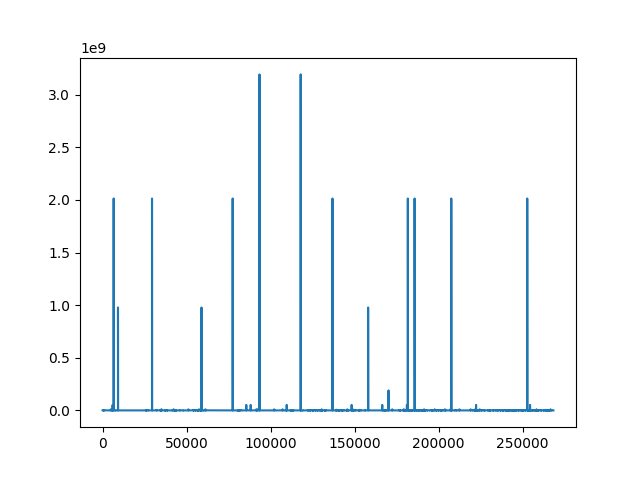

In [66]:
plt.figure()
plt.plot(losses)

In [67]:
losses = pd.Series(losses)
losses = losses.loc[losses > 0.5 * 1e9]

In [68]:
losses

6618      2.013964e+09
6619      2.013964e+09
9190      9.781098e+08
9191      9.781098e+08
29443     2.013964e+09
29444     2.013964e+09
58902     9.781098e+08
58903     9.781098e+08
77444     2.013964e+09
77445     2.013964e+09
93418     3.193602e+09
93419     3.193602e+09
117922    3.193602e+09
117923    3.193602e+09
136857    2.013964e+09
136858    2.013964e+09
158076    9.781098e+08
158077    9.781098e+08
181706    2.013964e+09
181707    2.013964e+09
185724    2.013964e+09
185725    2.013964e+09
207565    2.013964e+09
207566    2.013964e+09
252778    2.013964e+09
252779    2.013964e+09
dtype: float64

In [69]:
test_data_1_abnormal = test_data_1.loc[losses.index]

In [70]:
test_data_1_abnormal

,Source,Destination,Length,source_port,destination_port,windows_size_val
6618,10016139,82202185148,70,50624,443,64240
6619,10016139,82202185148,70,50624,443,64240
9190,10016139,40127240158,70,50623,443,64240
9191,10016139,40127240158,70,50623,443,64240
29443,10016139,82202185148,70,50624,443,64240
29444,10016139,82202185148,70,50624,443,64240
58902,10016139,40127240158,70,50623,443,64240
58903,10016139,40127240158,70,50623,443,64240
77444,10016139,82202185148,70,50624,443,64240
77445,10016139,82202185148,70,50624,443,64240


Проанализируем второй тестовый датасет

In [71]:
test_data_2 = data_init('test_2.csv')

In [72]:
test_data_2.isnull().sum()

Source              50
Destination         50
Length               0
source_port          0
destination_port     0
windows_size_val     0
dtype: int64

In [73]:
test_data_2 = test_data_2.dropna()

In [74]:
test_data_2.isnull().sum()

Source              0
Destination         0
Length              0
source_port         0
destination_port    0
windows_size_val    0
dtype: int64

<IPython.core.display.Javascript object>


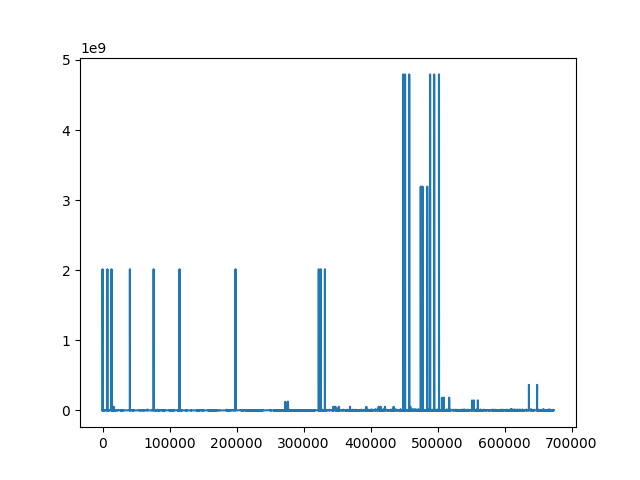

In [95]:
X_test = torch.FloatTensor(np.asarray(test_data_2))
preds = predict(X_test)
X_test_tmp = np.asarray(X_test)
losses = np.sum(np.abs(X_test_tmp - preds),axis=1)
plt.figure()
plt.plot(losses)

In [97]:
losses = pd.Series(losses)
losses = losses.loc[losses > 1 * 1e9]

In [100]:
test_data_2_abnormal = test_data_2.loc[losses.index]
test_data_2_abnormal

,Source,Destination,Length,source_port,destination_port,windows_size_val
15,10016140.0,8.220218e+10,70,55002,443,64240
7212,10016140.0,8.220218e+10,70,55003,443,64240
7213,10016140.0,8.220218e+10,70,55003,443,64240
13390,10016140.0,8.220218e+10,70,55003,443,64240
13391,10016140.0,8.220218e+10,70,55003,443,64240
40809,10016140.0,8.220218e+10,70,55003,443,64240
40810,10016140.0,8.220218e+10,70,55003,443,64240
76226,10016140.0,8.220218e+10,70,55004,443,64240
76227,10016140.0,8.220218e+10,70,55004,443,64240
114883,10016140.0,8.220218e+10,70,55004,443,64240


Проанализируем третий тестовый датасет

In [101]:
test_data_3 = data_init('test_3.csv')

In [102]:
test_data_3.isnull().sum()

Source              0
Destination         0
Length              0
source_port         0
destination_port    0
windows_size_val    0
dtype: int64

<IPython.core.display.Javascript object>


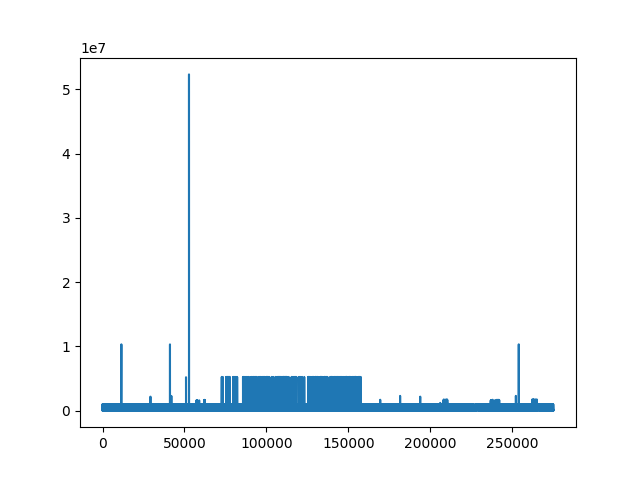

In [103]:
X_test = torch.FloatTensor(np.asarray(test_data_3))
preds = predict(X_test)
X_test_tmp = np.asarray(X_test)
losses = np.sum(np.abs(X_test_tmp - preds),axis=1)
plt.figure()
plt.plot(losses)

In [104]:
losses = pd.Series(losses)
losses = losses.loc[losses > 0.5 * 1e7]
losses.shape

(600,)

In [105]:
test_data_3_abnormal = test_data_3.loc[losses.index]
test_data_3_abnormal.head()

,Source,Destination,Length,source_port,destination_port,windows_size_val
11488,10108115,100109143,70,57986,13000,65535
11489,10108115,100109143,70,57986,13000,65535
41145,10108122,100112228,70,63396,13000,65535
41146,10108122,100112228,70,63396,13000,65535
50936,10026100,10017201,70,445,61858,4103
